# CNTK 208: Time Series Density Forecasting with residual LSTM
## Part B: Training and Forecasting

This is the second part of the tutorial that shows a full cycle of working with time series. We will also show how to create and use a custom loss function to enable a neural network to perform Density Forecasting or Quantile Regression.

In this part we will be training a neural network and then perform forecasting using datasets prepared and saved in Part A.

First, let's import a few modules and do some configuration:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as m
import random

import cntk.ops as o
import cntk.layers as l
import cntk
from cntk import Trainer
#from cntk.device import gpu, set_default_device #, cpu
from cntk.learner import *
from cntk.utils import get_train_loss #, sanitize_batch, get_train_eval_criterion,

pd.set_option("display.width", 200)
# Config matplotlib for inline plotting
%matplotlib inline

Now, setting up a few constants and reading the preprocessed files:

In [2]:
SEASONALITY=12
OUTPUT_SIZE=12
INPUT_SIZE_MULTIP=1.25  # using some reasoning and backesting, I decided to make input size a bit (here by 25%) larger than the maximum prediction horizon
INPUT_SIZE=int(INPUT_SIZE_MULTIP*OUTPUT_SIZE)

data_dir = './data/CIF_data'
train_filename = data_dir + '/train.csv'
validation_filename = data_dir + '/validation.csv'
test_filename = data_dir + '/test.csv'
    
train_df=pd.read_csv(train_filename) 
valid_df=pd.read_csv(validation_filename) 
test_df=pd.read_csv(test_filename) 
#type(train_df); train_df.shape; print(train_df)
#print(type(valid_df)); print(valid_df.shape); print(valid_df)
#print(type(test_df)); print(test_df.shape); print(test_df)

## Density Forecast and Pinball Loss
Traditionaly, only a single, most likely value is forecasted for a particular horizon - this is called "point forecast". A neural network can be trained to produce such forecast by using sum of squares error criterion (sum is over the forecast horizon). However, the point forecast is often not sufficient - we would like to know not only the most likely value, but also a few percentiles, like 5, 95, 99 of the forecast, called forecasting intervals, and potentially the full distribution of the forecast - the density forecast, see an image below from [prof R.Hyndman's blog]:
<img src="http://robjhyndman.com/hyndsight/files/2014/09/Rplot.png", width=450, height=300>

The issue here is similar to replacing a standard (e.g. linear) regression with [quantile regression] and is solved by replacing sum of squares loss with [pinball loss], which is defined as follows.

    (t-z)*tau when t>=z
    (z-t)*(1-tau) otherwise,
where t is the actual (true) value, z the quantile forecast, tau is the quantile probability (e.g. 0.95). 
For example, in case of 95p, when the actual value turns out to be larger than the forecasted quantile z, the loss equals the difference multplied by 0.95, but when the actual is smaller, the loss is equal to the (always positive) difference multiplied by 0.05, so much smaller penalty. While at first look the loss function may appear a bit strange, it can be [proven quite simply] that minimizing this loss leads to quantile regression.

## Pinball Loss
In CNTK, it is easily possible to create your own loss function using Python APIs for this tutorial. Here goes the Python version:

[quantile regression]: http://https://en.wikipedia.org/wiki/Quantile_regression
[pinball loss]: https://www.lokad.com/pinball-loss-function-definition
[proven quite simply]: https://en.wikipedia.org/wiki/Quantile_regression#Quantiles
[prof R.Hyndman's blog]: http://robjhyndman.com/hyndsight/quantile-forecasts-in-r/

In [3]:
def PinballLoss (z, t, tau):
  tauV=o.Constant(tau, shape=t.shape, dtype=np.float32)
  tau1mV=o.Constant(1-tau, shape=t.shape, dtype=np.float32)
  loss=o.reduce_sum(o.element_select(o.greater_equal(t, z), o.element_times(o.minus(t,z), tauV), o.element_times(o.minus(z,t), tau1mV)))
  return loss

We also define another loss function, QuantileLoss, which is related to PinballLoss, but normalized, and will be used only for reporting, not by  CNTK, therefore uses pure Python. 

In [4]:
def QuantileLoss (z, t, tau):
  loss=0
  for i in range(len(z)):
    if (t[i]>=z[i]):
      loss=loss+tau*(t[i]-z[i])
    else:
      loss=loss+(1-tau)*(z[i]-t[i])
  return loss/np.sum(t)*200.

## Model

In this tutorial we will use 3 percentiles: 5, 50 (which plays the role of the expected value), and 95, so there will be 3 independent network

In [5]:
PERCENTILES=np.asfarray([5,50,95])
POSITION_OF_MEDIAN=int(np.where(PERCENTILES==50)[0])
QUANTILES=PERCENTILES/100.
NUM_OF_NETS=len(QUANTILES)

The overall system architecture:
<img src="https://az712634.vo.msecnd.net/tutorials/Forecasting-Short-Time-Series-with-LSTM-Neural-Networks/5.png", width=300, height=300>

Following two functions are used for creating the network shown above, where the cetral role is played by a single LSTM network. However, the createLSTM_ResNet() function below is capable of creating a stack of LSTM networks with "bypasses", and has been inspired by Residual Network [ResNet] that won ImageNet 2015 competition.
For example, we could run with two LSTM networks:
<img src="Figure-1-The-RNN-architecture.png", width=250, height=250>

However, the data set we are using here is just too small to support this more complicated network, you can experiment yourself, but you are likely to find that the training time increases, while the accuracy does not. On the other hand I did find this kind of deeper network [performing well] on a dataset containing a few hundread time series.
The size of the LSTM state does not need to be large and needs to be established experimentally, e.g. one can try narrower but deeper network. Here we are using 10.

[ResNet]: https://arxiv.org/pdf/1512.03385v1.pdf
[performing well]: https://forecasters.org/wp-content/uploads/gravity_forms/7-621289a708af3e7af65a7cd487aee6eb/2016/07/Smyl_Slawek_ISF2016.pdf

In [6]:
NUM_HIDDEN_LAYERS=1
HIDDEN_DIM=10
LSTM_USE_PEEPHOLES=False
LSTM_USE_STABILIZATION=False


def linear_layer_withNoBias(input_var, output_dim):
  input_dim = input_var.shape[0]
  times_param = o.parameter(shape=(input_dim, output_dim))
  t=o.times(input_var, times_param)
  return t

def createLSTM_ResNet(input_var , num_hidden_layers1, hidden_layer_dim1, output_dim):
  r=l.Recurrence(l.LSTM(hidden_layer_dim1, 
    use_peepholes=LSTM_USE_PEEPHOLES,
    enable_self_stabilization=LSTM_USE_STABILIZATION))(input_var)
  for i in range(1, num_hidden_layers1):
    r1=l.Recurrence(l.LSTM(hidden_layer_dim1, 
      use_peepholes=LSTM_USE_PEEPHOLES,
      enable_self_stabilization=LSTM_USE_STABILIZATION))(r)
    r=r+r1    
  return linear_layer_withNoBias(r, output_dim)

Training of a recurrent neural network requires attention to the order in which samples are used: the natural time order needs to be preserved within one sequence/time series, while it is beneficial to shuffle the whole sequences. To facilitate it, we create lists whose members hold inputs, outputs, etc. of a single time series.

In [7]:
trainingList=[]
series=np.unique(train_df['series']) 
#ser=series[0]
for ser in series:
  oneSeries_df=train_df[train_df['series']==ser]
  # oneSeries_df.iloc[1,]
  inputs_df=oneSeries_df.iloc[:,range(1,(INPUT_SIZE+1))]
  outputs_df=oneSeries_df.iloc[:,range((INPUT_SIZE+1),(INPUT_SIZE+1+OUTPUT_SIZE))]
  dat={"inputs":np.asfarray(inputs_df), "outputs":np.asfarray(outputs_df)}
  trainingList.append(dat) #len(trainingList)

validationList=[]; listOfValidationInputs=[]
series=np.unique(valid_df['series']) 
#ser=series[0]
for ser in series:
  oneSeries_df=valid_df[valid_df['series']==ser]
  #oneSeries_df.iloc[1,:]
  inputs_df=oneSeries_df.iloc[:,range(1,(INPUT_SIZE+1))]
  outputs_df=oneSeries_df.iloc[:,range((INPUT_SIZE+1),(INPUT_SIZE+1+OUTPUT_SIZE))]
  levels=np.asfarray(oneSeries_df['level'])
  lastIndx=levels.shape[0]-1
  lastLevel=levels[lastIndx]
  lastSeasonality_df=oneSeries_df.iloc[lastIndx,range((INPUT_SIZE+2+OUTPUT_SIZE),(INPUT_SIZE+2+2*OUTPUT_SIZE))]
  lastSeasonality=np.asfarray(lastSeasonality_df)
  seasonalityPlusLevel=lastSeasonality+lastLevel
  lastActuals_df=oneSeries_df.iloc[oneSeries_df.shape[0]-1,range((oneSeries_df.shape[1]-INPUT_SIZE-OUTPUT_SIZE),(oneSeries_df.shape[1]))]
  dat={"series":ser, "inputs":np.asfarray(inputs_df), "outputs":np.asfarray(outputs_df), 
    "seasonalityPlusLevel":np.asfarray(seasonalityPlusLevel), "actuals":np.asfarray(lastActuals_df)}
  listOfValidationInputs.append(dat["inputs"])
  validationList.append(dat)  #len(validationList)

testList=[]; listOfTestInputs=[]
series=np.unique(test_df['series']) 
#ser=series[0]
for ser in series:
  oneSeries_df=test_df[test_df['series']==ser]
  #oneSeries_df.iloc[1,:]
  inputs_df=oneSeries_df.iloc[:,range(1,(INPUT_SIZE+1))]
  #outputs_df=oneSeries_df.iloc[:,range((INPUT_SIZE+1),(INPUT_SIZE+1+OUTPUT_SIZE))]
  levels=np.asfarray(oneSeries_df['level'])
  lastIndx=levels.shape[0]-1
  lastLevel=levels[lastIndx]
  lastSeasonality_df=oneSeries_df.iloc[lastIndx,range((INPUT_SIZE+2+OUTPUT_SIZE),(INPUT_SIZE+2+2*OUTPUT_SIZE))]
  seasonalityPlusLevel=lastSeasonality+lastLevel
  dat={"series":ser, "inputs":np.asfarray(inputs_df), "seasonalityPlusLevel":np.asfarray(seasonalityPlusLevel)}
  listOfTestInputs.append(np.ascontiguousarray(dat["inputs"]))
  testList.append(dat) # len(testList);testList[1] 

Create networks and the associate CNTK's objects like Trainer. Please note the definition of Trainer - it uses the PinballLoss function and the advanced adam_sgd learner with L2 and noise injection regularization. The noise injection is very useful tool, protecting to some extend against overtraining.
Mini-batch size was set to 50 after some experimentation - smaller values make learning slower, but do not improve learning.

In [9]:
#set_default_device(gpu(0))
learning_rate = 2e-3
MB_SIZE=50
momentumAsTimeConstant = -MB_SIZE/m.log(0.9)

listOfTrainers=[]; 
inputs = o.input_variable(INPUT_SIZE, np.float32)
labels = o.input_variable(OUTPUT_SIZE, np.float32)
quantileLossListOfLists=[]
for inet in range(NUM_OF_NETS):
  quantileLossListOfLists.append([])
  z = createLSTM_ResNet(inputs , NUM_HIDDEN_LAYERS, HIDDEN_DIM, OUTPUT_SIZE)
  tau=QUANTILES[inet]
  loss = PinballLoss(z, labels, tau)
  eval_error = PinballLoss(z, labels, tau)
  lr_schedule = learning_rate_schedule(learning_rate, UnitType.sample) 
  mom_schedule = momentum_as_time_constant_schedule(momentumAsTimeConstant)
  #learner = momentum_sgd(z.parameters, lr_schedule, mom_schedule, l2_regularization_weight=0.001, gaussian_noise_injection_std_dev=0.0005)
  #learner = adagrad(z.parameters, lr=lr_schedule, l2_regularization_weight=0.001, gaussian_noise_injection_std_dev=0.0005)
  learner = adam_sgd(z.parameters, lr=lr_schedule, momentum=mom_schedule, variance_momentum = momentum_as_time_constant_schedule(1), 
                     l2_regularization_weight=0.001, gaussian_noise_injection_std_dev=0.001)
  trainer = Trainer(z, (loss, eval_error), learner)
  listOfTrainers.append(trainer)

## Training
In this part of project one would spend a lot of time trying different learners, network structures, parameters (so also modifying and rerunning the network setup above). Here, as an example, we will just choose number of training epochs. 

Please note how we create a minibatch: we are accumulating records into a list, whose each element contains records of one series, so CNTK knows they are separate series, and therefore the RNN state is not shared accross the series. When the total number of records accumulated is larger than the mini-batch size, we execute one mini-batch training, actually 3 of them, for each network (percentile). 

We are using training set for training, but from time to time (every INFO_FREQ epoch) we check how the networks perform on validation data set, specifically last point of each series within the validation set. We print bias of 50p forecast and quantile losses for all 3 percentiles, and plot one randomly selected case.

Epoch: 0, Train Loss: 0.241 bias: 3.39 Quantile loss: [ 4.96  8.65  2.8 ]
Epoch: 1, Train Loss: 0.236 bias: 3.49 Quantile loss: [ 5.21  8.51  2.73]
Epoch: 2, Train Loss: 0.228 bias: 2.89 Quantile loss: [ 4.92  8.36  2.64]
Epoch: 3, Train Loss: 0.232 bias: 3.3 Quantile loss: [ 4.61  8.25  2.72]
Epoch: 4, Train Loss: 0.224 bias: 3.28 Quantile loss: [ 4.45  8.19  2.64]
Epoch: 5, Train Loss: 0.226 bias: 5.25 Quantile loss: [ 4.62  8.23  2.58]
Epoch: 6, Train Loss: 0.233 bias: 1.93 Quantile loss: [ 4.54  8.14  2.52]
Epoch: 7, Train Loss: 0.217 bias: 2.76 Quantile loss: [ 4.44  8.08  2.5 ]
Epoch: 8, Train Loss: 0.234 bias: 3.21 Quantile loss: [ 4.41  8.03  2.48]
Epoch: 9, Train Loss: 0.232 bias: 2.39 Quantile loss: [ 4.43  7.99  2.44]
Epoch: 10, Train Loss: 0.212 bias: 3.27 Quantile loss: [ 4.45  7.96  2.41]
Epoch: 11, Train Loss: 0.221 bias: 2.38 Quantile loss: [ 4.37  7.94  2.39]
Epoch: 12, Train Loss: 0.212 bias: 2.18 Quantile loss: [ 4.32  7.91  2.38]
Epoch: 13, Train Loss: 0.21 bias: 1.

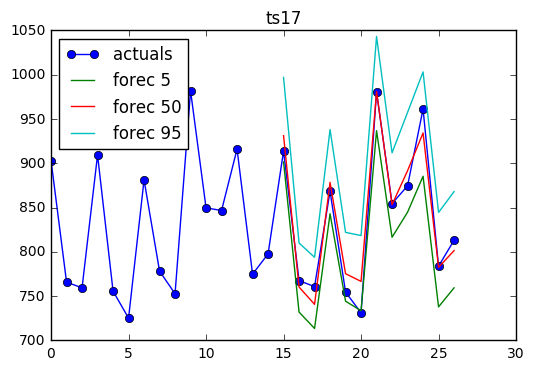

In [11]:
INFO_FREQ=1
MAX_NUM_OF_EPOCHS=100
#epoch=0;iseries=0; inet=0
for epoch in range(MAX_NUM_OF_EPOCHS):
  random.shuffle(trainingList)
  loss=[]; 
  numRecordsToBeProcessed=0; listOfInputs=[]; listOfLabels=[] 
  for iseries in range(len(trainingList)):
    series=trainingList[iseries]
    
    # listOfInputs.append(series["inputs"]); listOfLabels.append(series["outputs"]); # len(listOfInputs)

    listOfInputs.append(np.ascontiguousarray(series["inputs"])); 
    listOfLabels.append(np.ascontiguousarray(series["outputs"])); # len(listOfInputs)
    
    numRecordsToBeProcessed=numRecordsToBeProcessed+series["inputs"].shape[0]
    if numRecordsToBeProcessed>MB_SIZE or iseries==len(trainingList)-1:
      for inet in range(NUM_OF_NETS):
        trainer=listOfTrainers[inet]
        trainer.train_minibatch({inputs:listOfInputs, labels:listOfLabels})
        training_loss = get_train_loss(trainer)
        loss.append(training_loss)
    
      numRecordsToBeProcessed=0; listOfInputs=[];  listOfLabels=[]
      
  if epoch%INFO_FREQ==0:
    training_loss=np.mean(loss)
    bias_list=[]; validation_outputs=[] 
    for inet in range(NUM_OF_NETS):
      tau=QUANTILES[inet]
      trainer=listOfTrainers[inet]
        
      newlistOfValidationInputs = [np.ascontiguousarray(item) for item in listOfValidationInputs]
    
      validation_output=trainer.model.eval({inputs: newlistOfValidationInputs})
      validation_outputs.append(validation_output) 
      # type(validation_output); len(validation_output);validation_output[1] validation_output[31].shape
      # il=0  
      for il in range(len(validation_output)):
        series=validationList[il]
        oneValidationOut=validation_output[il]
        #oneValidationOutout.shape
        lastOneValidationOutput=oneValidationOut[oneValidationOut.shape[0]-1,]
        validationOutputUnwind=np.exp(lastOneValidationOutput+series["seasonalityPlusLevel"])
        actuals=series["actuals"][range(len(series["actuals"])-OUTPUT_SIZE,len(series["actuals"]))]
        if inet==POSITION_OF_MEDIAN:
          bias=np.sum(validationOutputUnwind-actuals)/np.sum(actuals)*100
          bias_list.append(bias)
        quantileLossListOfLists[inet].append(QuantileLoss (validationOutputUnwind, actuals, tau))
      
    #len(validation_outputs)  
    bias=np.mean(bias_list)
    quantileLossList=[]
    for inet in range(NUM_OF_NETS):
      quantileLossList.append(np.mean(quantileLossListOfLists[inet]))
    print ("Epoch: {}, Train Loss: {} bias: {} Quantile loss: {}".format(epoch, np.round(training_loss,3), np.round(bias,2), np.round(quantileLossList,2))) 
    irand=random.randint(0,len(validation_output)-1)
    series=validationList[irand] 
    actuals=series["actuals"]
    seriesName=series["series"]
    plt.clf()
    plt.plot(actuals,'o-', label='actuals')
    for inet in range(NUM_OF_NETS):
      oneValidationOut=validation_outputs[inet][irand]
      lastOneValidationOutput=oneValidationOut[oneValidationOut.shape[0]-1,]
      validationOutputUnwound=np.exp(lastOneValidationOutput+series["seasonalityPlusLevel"])
      plt.plot(range(len(actuals)-OUTPUT_SIZE,len(actuals)), validationOutputUnwound, label='forec '+str(int(PERCENTILES[inet])))
    plt.legend(loc='upper left')
    plt.title(seriesName)    
    plt.pause(0.0001)
    
    

## Final Training
Let's say that the experiments convinced us that there is no benefit, but most likely still some danger of overfitting (despite adding the regularization noise) in training for more than 70 epochs. So now we recreate the net using the same architecture and parameters and then train on the validation data set. We perform only the training, as we do not have here an additional data set to check out-of-smaple performance as before.

In [13]:
listOfTrainers=[]; 
inputs = o.input_variable(INPUT_SIZE, np.float32)
labels = o.input_variable(OUTPUT_SIZE, np.float32)
quantileLossListOfLists=[]
for inet in range(NUM_OF_NETS):
  quantileLossListOfLists.append([])
  z = createLSTM_ResNet(inputs , NUM_HIDDEN_LAYERS, HIDDEN_DIM, OUTPUT_SIZE)
  tau=QUANTILES[inet]
  loss = PinballLoss(z, labels, tau)
  eval_error = PinballLoss(z, labels, tau)
  lr_schedule = learning_rate_schedule(learning_rate, UnitType.sample) 
  mom_schedule = momentum_as_time_constant_schedule(momentumAsTimeConstant)
  learner = adam_sgd(z.parameters, lr=lr_schedule, momentum=mom_schedule, variance_momentum = momentum_as_time_constant_schedule(1), 
                     l2_regularization_weight=0.001, gaussian_noise_injection_std_dev=0.001)
  trainer = Trainer(z, (loss, eval_error), learner)
  listOfTrainers.append(trainer)


MAX_NUM_OF_EPOCHS=70
for epoch in range(MAX_NUM_OF_EPOCHS):
    random.shuffle(validationList)
    loss=[]; 
    numRecordsToBeProcessed=0; listOfInputs=[]; listOfLabels=[] 
    for iseries in range(len(validationList)):
        series=validationList[iseries]
        listOfInputs.append(np.ascontiguousarray(series["inputs"])) 
        listOfLabels.append(np.ascontiguousarray(series["outputs"])); # len(listOfInputs)
        numRecordsToBeProcessed=numRecordsToBeProcessed+series["inputs"].shape[0]
        if numRecordsToBeProcessed>MB_SIZE or iseries==len(validationList)-1:
            for inet in range(NUM_OF_NETS):
                trainer=listOfTrainers[inet]
                trainer.train_minibatch({inputs:listOfInputs, labels:listOfLabels})
                training_loss = get_train_loss(trainer)
                loss.append(training_loss)
    
            numRecordsToBeProcessed=0; listOfInputs=[];  listOfLabels=[]
      
    if epoch%INFO_FREQ==0:
        training_loss=np.mean(loss)
        print ("Epoch: {}, Train Loss: {}".format(epoch, np.round(training_loss,3)))

Epoch: 0, Train Loss: 0.303
Epoch: 1, Train Loss: 0.245
Epoch: 2, Train Loss: 0.232
Epoch: 3, Train Loss: 0.235
Epoch: 4, Train Loss: 0.236
Epoch: 5, Train Loss: 0.263
Epoch: 6, Train Loss: 0.236
Epoch: 7, Train Loss: 0.227
Epoch: 8, Train Loss: 0.231
Epoch: 9, Train Loss: 0.229
Epoch: 10, Train Loss: 0.218
Epoch: 11, Train Loss: 0.22
Epoch: 12, Train Loss: 0.219
Epoch: 13, Train Loss: 0.234
Epoch: 14, Train Loss: 0.228
Epoch: 15, Train Loss: 0.25
Epoch: 16, Train Loss: 0.21
Epoch: 17, Train Loss: 0.233
Epoch: 18, Train Loss: 0.215
Epoch: 19, Train Loss: 0.225
Epoch: 20, Train Loss: 0.252
Epoch: 21, Train Loss: 0.228
Epoch: 22, Train Loss: 0.219
Epoch: 23, Train Loss: 0.213
Epoch: 24, Train Loss: 0.222
Epoch: 25, Train Loss: 0.228
Epoch: 26, Train Loss: 0.221
Epoch: 27, Train Loss: 0.218
Epoch: 28, Train Loss: 0.226
Epoch: 29, Train Loss: 0.215
Epoch: 30, Train Loss: 0.219
Epoch: 31, Train Loss: 0.216
Epoch: 32, Train Loss: 0.217
Epoch: 33, Train Loss: 0.214
Epoch: 34, Train Loss: 0.21

## Final Forecast
Now we apply our trained nets on the test data set to produce the final forecast, and then we create and print a data frame with the results.

In [ ]:
test_outputs=[]
for inet in range(NUM_OF_NETS):
  trainer=listOfTrainers[inet]
  test_output=trainer.model.eval({inputs: listOfTestInputs})
  test_outputs.append(test_output)
   
save_df=None   
# il=0  
for il in range(len(test_output)):
  series=testList[il]
  seriesName=series["series"]
  for inet in range(NUM_OF_NETS):
    tau=QUANTILES[inet]
    test_output=test_outputs[inet]
    onetestOut=test_output[il]
    #onetestOutout.shape
    lastOnetestOutput=onetestOut[onetestOut.shape[0]-1,]
    testOutputUnwind=np.exp(lastOnetestOutput+series["seasonalityPlusLevel"])
    sav_df=pd.DataFrame(data=[seriesName], columns=['series'])
    sav_df['percentile']=tau
    for ih in range(len(testOutputUnwind)):
      sav_df['h'+str(ih+1)]=testOutputUnwind[ih]
    if save_df is None:
      save_df=sav_df
    else:
      save_df=save_df.append(sav_df)
print(save_df.iloc[1,:])           

## Done
Congratulations! All done. Except perhaps checking how we did in "real-life" - now you could download the competition testing dataset (that contains actuals revealed only after the competition finished) from http://irafm.osu.cz/cif/cif-results.txt and calculate some metrics.      